<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/leonardo_lellis/Aula_4_Exerc%C3%ADcio_Leonardo_de_Lellis_Rossi_RA261900.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

import random
import math
from tqdm import tqdm

## Fixando as seeds

In [2]:
def set_seeds():
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)

set_seeds()  

# Neptune

In [3]:
 !pip install -U neptune-client
 import neptune.new as neptune
 

     |████████████████████████████████| 316 kB 5.2 MB/s 
     |████████████████████████████████| 829 kB 6.9 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 181 kB 44.8 MB/s 
     |████████████████████████████████| 132 kB 49.9 MB/s 
     |████████████████████████████████| 79 kB 5.2 MB/s 
     |████████████████████████████████| 8.7 MB 32.9 MB/s 
     |████████████████████████████████| 138 kB 45.8 MB/s 
     |████████████████████████████████| 63 kB 892 kB/s 
     |████████████████████████████████| 127 kB 47.6 MB/s 
     |████████████████████████████████| 67 kB 3.0 MB/s 
     |████████████████████████████████| 130 kB 72.8 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.16.1-py2.py3-none-any.whl size=565960 sha256=2806bd90435df2bde89bc7a8dfd705770c042f996376676adff5bb52166151cf
  Stored in directory: /root/.cache/pip/wheels/8b/1a/02/10440cbdf7d5e3a3a13aab8ed77dfb

In [4]:
run = neptune.init(
    project="leolellisr/dl-ia025",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==",
)

https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-23


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Dataset e dataloader

### Definição do tamanho do minibatch

In [5]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [6]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [7]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [8]:
from torchvision.transforms.autoaugment import TrivialAugmentWide
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

debug = True
def set_seeds():
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)

set_seeds()
# dataset wrapper class

class Ex4Dataloader():
  def __init__(self, dataset, batch_size=1, shuffle=False):

#    Args:
#          dataset: dataset object
#          batch_size: int, how many images used by batch (group of images used by epoch) (default: 1)
#          shuffle: bool, if True the images are reorganized randomically each epoch (default: False)   

    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.idx = 0
    self.idx_list = [range(i,i+self.batch_size) for i in range(0, len(self.dataset), self.batch_size)]


  def __shuffle(self):
    # List random indexes with dataset len
    random_idx = np.arange(len(self.dataset))
    np.random.shuffle(random_idx) 
    self.idx_list = [random_idx[i:i+self.batch_size] for i in range(0, len(self.dataset), self.batch_size)]
  
  def __len__(self):
    # math.ceil returns the smallest integer greater than or equal to the number
    # https://docs.python.org/3/library/math.html
    return math.ceil(len(self.dataset)/self.batch_size)

  def __split_data(self):
    # get data with actual index 
    #idxs = self.idx_list[self.idx]
    idxs = np.array(self.idx_list[self.idx])
    if debug:
      print(f'idxs: {len(idxs)}')
      print(f'dataset: {len(self.dataset)}')

    # Agradecimentos ao colega Pedro Gengo. Estava tendo problemas ao pegar as labels do dataset  
    inputs = [torch.unsqueeze(self.dataset[idx][0], 0) for idx in idxs]
    labels = [torch.tensor([self.dataset[idx][1]], dtype=torch.int64) for idx in idxs]
    #inputs, labels = self.dataset[idxs]
    return torch.cat((inputs), 0), torch.cat((labels), 0)


  def __iter__(self):
    self.idx = 0
    return self

  def __next__(self):
    if self.idx == 0:
      if self.shuffle:
        self.__shuffle()
      
    if self.idx < len(self.idx_list):
      input,label = self.__split_data()
      self.idx+=1
      return input,label 
    else:
      if debug:
        print("idx: ", self.idx)
        print("idx_list: ", len(self.idx_list))
      raise StopIteration



In [9]:

loader_train = Ex4Dataloader(dataset_train, batch_size, False)


print('Número de minibatches de treinamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de treinamento: 20
idxs: 50
dataset: 1000

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [10]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))
class SumNode():
  def forward(self, x, y):
    return x + y

class MulNode():
  def forward(self, x, y):
    self.x = x
    self.y = y
    return torch.matmul(x, y)

class MyLinear():
    def __init__(self, in_features, out_features, bias=True):
        self.mul = MulNode()
        self.sum = SumNode()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = torch.randn(in_features, out_features,  requires_grad=True)
        if bias:
            self.bias = torch.ones(out_features, requires_grad=True)
        else:
            self.bias = None

    def zero_grad(self):
        if self.weights.grad is not None:
            self.weights.grad.zero_()
        if self.bias is not None:
            if self.bias.grad is not None:
                self.bias.grad.zero_()

    def forward(self, x):
      mul = self.mul.forward(x, self.weights)
      out = self.sum.forward(mul, self.bias)
      if self.bias is not None:
        out += self.bias
      return out

model = MyLinear(28*28, 10)

In [11]:
_ = next(iter(loader_train))[0].view(-1, 28*28)
_.shape, _.dtype

idxs: 50
dataset: 1000


(torch.Size([50, 784]), torch.float32)

## Treinamento

### Inicialização dos parâmetros

In [12]:
params = {'n_epochs': 50,
          'lr': 0.15,
          'Loss': 'CrossEntropyLoss',
          'optimizer': 'SGD',
         }

# Neptune
run['parameters'] = params
set_seeds()
model = MyLinear(28*28, 10, True)

## Definição da Loss



In [13]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

def softmax(logits):
  # get target logits
  logits_max, _ = torch.max(logits, axis=-1, keepdims=True)
 
  logits = logits - logits_max  

  #S(Zi) = exp^zi/SUM(exp^zj)
  e_logits = torch.exp(logits) 
  return e_logits/torch.sum(e_logits, axis=-1, keepdims=True)

def cross_entropy_loss(logits, labels):
    # logits: output NN 
    # labels: label 
    
    # softmax
    y_pred = softmax(logits)

    #batch_size is used in mean calculation      
    batch_size = y_pred.shape[0]
    loss =  - torch.sum(torch.log(y_pred[torch.arange(batch_size), labels])) / batch_size
    return loss

criterion = cross_entropy_loss


# Definição do Optimizer

In [14]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)
from typing import List
debug = False
class SGD():
    def __init__(self, parameters, learning_rate: float):
        self.lr = learning_rate
        self.params = parameters

    def step(self):
        for param in self.params:
          if debug:
            print(f"before SGD: parameter = {param.data}")
            print(f"parameter.grad = {param.grad}")
          param.data -= self.lr * param.grad  
          if debug: print(f"after SGD: parameter = {param.data}")
          
    def zero_grad(self):
        for param in self.params:
          param.grad = torch.zeros(param.data.size(), dtype=param.data.dtype)

optimizer = SGD(parameters=[model.weights, model.bias], learning_rate=params['lr'])

### Laço de treinamento dos parâmetros

In [15]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

for i in tqdm(range(params["n_epochs"])):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model.forward(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        # loss.backward()
        # 
        model.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            model.weights -= params['lr'] * model.weights.grad
            if model.bias is not None:
                model.bias -= params['lr'] * model.bias.grad
        optimizer.step()
        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())
        run['train/loss'].log(loss.item()) # Envia loss para o Neptune.

    loss_epoch_end.append(loss.item())
    run['train/loss_end'].log(loss.item()) # Envia loss para o Neptune.
    print(f'Epoch: {i:d}/{params["n_epochs"] - 1:d} Loss: {loss.item()}')

run.stop()

  2%|▏         | 1/50 [00:00<00:24,  1.97it/s]

Epoch: 0/49 Loss: 4.841966152191162


  4%|▍         | 2/50 [00:00<00:18,  2.53it/s]

Epoch: 1/49 Loss: 2.6448724269866943


  6%|▌         | 3/50 [00:01<00:14,  3.18it/s]

Epoch: 2/49 Loss: 1.9491077661514282


  8%|▊         | 4/50 [00:01<00:12,  3.63it/s]

Epoch: 3/49 Loss: 1.5677540302276611


 10%|█         | 5/50 [00:01<00:11,  3.89it/s]

Epoch: 4/49 Loss: 1.3373825550079346


 12%|█▏        | 6/50 [00:01<00:10,  4.11it/s]

Epoch: 5/49 Loss: 1.1919968128204346


 14%|█▍        | 7/50 [00:01<00:10,  4.16it/s]

Epoch: 6/49 Loss: 1.0926010608673096


 16%|█▌        | 8/50 [00:02<00:11,  3.55it/s]

Epoch: 7/49 Loss: 1.0147758722305298


 18%|█▊        | 9/50 [00:02<00:12,  3.18it/s]

Epoch: 8/49 Loss: 0.9486088752746582


 20%|██        | 10/50 [00:03<00:14,  2.77it/s]

Epoch: 9/49 Loss: 0.8904836773872375


 22%|██▏       | 11/50 [00:03<00:15,  2.46it/s]

Epoch: 10/49 Loss: 0.8386015295982361


 24%|██▍       | 12/50 [00:04<00:16,  2.30it/s]

Epoch: 11/49 Loss: 0.7914567589759827


 26%|██▌       | 13/50 [00:04<00:15,  2.40it/s]

Epoch: 12/49 Loss: 0.747832715511322


 28%|██▊       | 14/50 [00:04<00:15,  2.38it/s]

Epoch: 13/49 Loss: 0.7068129181861877


 30%|███       | 15/50 [00:05<00:14,  2.34it/s]

Epoch: 14/49 Loss: 0.6678230166435242


 32%|███▏      | 16/50 [00:06<00:16,  2.02it/s]

Epoch: 15/49 Loss: 0.6305761933326721


 34%|███▍      | 17/50 [00:06<00:15,  2.10it/s]

Epoch: 16/49 Loss: 0.5949300527572632


 36%|███▌      | 18/50 [00:07<00:15,  2.04it/s]

Epoch: 17/49 Loss: 0.560756504535675


 38%|███▊      | 19/50 [00:07<00:14,  2.12it/s]

Epoch: 18/49 Loss: 0.5278973579406738


 40%|████      | 20/50 [00:08<00:15,  1.96it/s]

Epoch: 19/49 Loss: 0.4962473213672638


 42%|████▏     | 21/50 [00:08<00:14,  1.94it/s]

Epoch: 20/49 Loss: 0.46588626503944397


 44%|████▍     | 22/50 [00:09<00:15,  1.76it/s]

Epoch: 21/49 Loss: 0.4370613992214203


 46%|████▌     | 23/50 [00:09<00:15,  1.71it/s]

Epoch: 22/49 Loss: 0.4100339412689209


 48%|████▊     | 24/50 [00:10<00:15,  1.71it/s]

Epoch: 23/49 Loss: 0.38493719696998596


 50%|█████     | 25/50 [00:10<00:13,  1.82it/s]

Epoch: 24/49 Loss: 0.36173015832901


 52%|█████▏    | 26/50 [00:11<00:12,  1.96it/s]

Epoch: 25/49 Loss: 0.3402518928050995


 54%|█████▍    | 27/50 [00:11<00:11,  2.02it/s]

Epoch: 26/49 Loss: 0.3202989101409912


 56%|█████▌    | 28/50 [00:12<00:11,  1.97it/s]

Epoch: 27/49 Loss: 0.3016832768917084


 58%|█████▊    | 29/50 [00:12<00:10,  2.01it/s]

Epoch: 28/49 Loss: 0.2842537760734558


 60%|██████    | 30/50 [00:13<00:10,  1.94it/s]

Epoch: 29/49 Loss: 0.26789456605911255


 62%|██████▏   | 31/50 [00:13<00:10,  1.87it/s]

Epoch: 30/49 Loss: 0.2525203227996826


 64%|██████▍   | 32/50 [00:14<00:08,  2.02it/s]

Epoch: 31/49 Loss: 0.23806782066822052


 66%|██████▌   | 33/50 [00:14<00:08,  2.03it/s]

Epoch: 32/49 Loss: 0.22448968887329102


 68%|██████▊   | 34/50 [00:15<00:07,  2.09it/s]

Epoch: 33/49 Loss: 0.21174851059913635


 70%|███████   | 35/50 [00:15<00:07,  2.13it/s]

Epoch: 34/49 Loss: 0.19981567561626434


 72%|███████▏  | 36/50 [00:16<00:06,  2.12it/s]

Epoch: 35/49 Loss: 0.18866673111915588


 74%|███████▍  | 37/50 [00:16<00:06,  1.94it/s]

Epoch: 36/49 Loss: 0.1782790571451187


 76%|███████▌  | 38/50 [00:17<00:06,  1.86it/s]

Epoch: 37/49 Loss: 0.16863150894641876


 78%|███████▊  | 39/50 [00:18<00:06,  1.64it/s]

Epoch: 38/49 Loss: 0.15969792008399963


 80%|████████  | 40/50 [00:18<00:05,  1.75it/s]

Epoch: 39/49 Loss: 0.15144897997379303


 82%|████████▏ | 41/50 [00:18<00:04,  2.14it/s]

Epoch: 40/49 Loss: 0.1438502073287964


 84%|████████▍ | 42/50 [00:19<00:03,  2.55it/s]

Epoch: 41/49 Loss: 0.13686372339725494


 86%|████████▌ | 43/50 [00:19<00:02,  2.92it/s]

Epoch: 42/49 Loss: 0.13045120239257812


 88%|████████▊ | 44/50 [00:19<00:01,  3.28it/s]

Epoch: 43/49 Loss: 0.12457401305437088


 90%|█████████ | 45/50 [00:19<00:01,  3.61it/s]

Epoch: 44/49 Loss: 0.11919565498828888


 92%|█████████▏| 46/50 [00:19<00:01,  3.88it/s]

Epoch: 45/49 Loss: 0.11427926272153854


 94%|█████████▍| 47/50 [00:20<00:00,  3.98it/s]

Epoch: 46/49 Loss: 0.10978838056325912


 96%|█████████▌| 48/50 [00:20<00:00,  4.06it/s]

Epoch: 47/49 Loss: 0.10568563640117645


 98%|█████████▊| 49/50 [00:20<00:00,  4.19it/s]

Epoch: 48/49 Loss: 0.10193298012018204


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]

Epoch: 49/49 Loss: 0.09849247336387634
Shutting down background jobs, please wait a moment...
Done!



Waiting for the remaining 91 operations to synchronize with Neptune. Do not kill this process.


All 91 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-23


### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

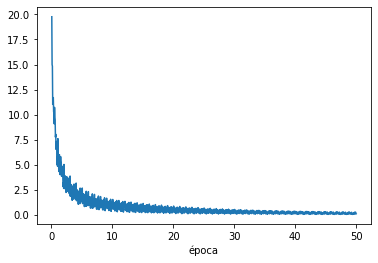

In [16]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

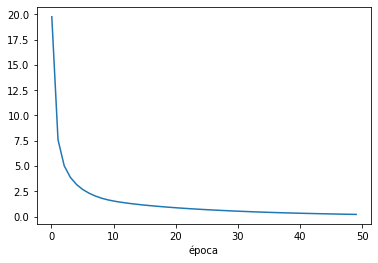

In [17]:

n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [18]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

AssertionError: ignored

In [19]:
loss_epoch_end

[4.841966152191162,
 2.6448724269866943,
 1.9491077661514282,
 1.5677540302276611,
 1.3373825550079346,
 1.1919968128204346,
 1.0926010608673096,
 1.0147758722305298,
 0.9486088752746582,
 0.8904836773872375,
 0.8386015295982361,
 0.7914567589759827,
 0.747832715511322,
 0.7068129181861877,
 0.6678230166435242,
 0.6305761933326721,
 0.5949300527572632,
 0.560756504535675,
 0.5278973579406738,
 0.4962473213672638,
 0.46588626503944397,
 0.4370613992214203,
 0.4100339412689209,
 0.38493719696998596,
 0.36173015832901,
 0.3402518928050995,
 0.3202989101409912,
 0.3016832768917084,
 0.2842537760734558,
 0.26789456605911255,
 0.2525203227996826,
 0.23806782066822052,
 0.22448968887329102,
 0.21174851059913635,
 0.19981567561626434,
 0.18866673111915588,
 0.1782790571451187,
 0.16863150894641876,
 0.15969792008399963,
 0.15144897997379303,
 0.1438502073287964,
 0.13686372339725494,
 0.13045120239257812,
 0.12457401305437088,
 0.11919565498828888,
 0.11427926272153854,
 0.10978838056325912,
 

# Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [20]:
# Escreva o código aqui:
set_seeds()
loader_test = Ex4Dataloader(dataset_train, 50, False)

print('Número de minibatches de treinamento:', len(loader_test))

x_test, y_test = next(iter(loader_test))
print("\nDimensões dos dados de um minibatch:", x_test.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_test), torch.max(x_test))
print("Tipo dos dados das imagens:         ", type(x_test))
print("Tipo das classes das imagens:       ", type(x_test))

Número de minibatches de treinamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [21]:
loader_test.__len__()

20

In [22]:
logits_a = []
y_true = []
y_pred = []
#y_prob = []

with torch.no_grad():
    for inputs, target in tqdm(loader_test, 'Predicting scores'):
        logits = model.forward(inputs.view(-1, 28 * 28))
        logits_a.append(logits)
        y_true.append(target)
y_true = torch.cat(y_true, dim=0).ravel()
logits_a = torch.cat(logits_a, dim=0)

# Probabilities ( logits softmax )
output = softmax(logits_a)

# Predict classes 
preds = output.argmax(-1)

print("\ny_true: ", y_true.shape)
print("\ny_pred: ", output.shape)
#y_prob = np.concatenate([y_prob], axis=None)
#print("y_prob: ", y_prob[1])

true_pred = output.argmax(-1) == y_true


print("\ntrue_pred: ", true_pred.shape)

print(f'\nAcc (%): {true_pred.float().mean()*100}')

Predicting scores: 100%|██████████| 20/20 [00:00<00:00, 102.32it/s]



y_true:  torch.Size([1000])

y_pred:  torch.Size([1000, 10])

true_pred:  torch.Size([1000])

Acc (%): 96.69999694824219


In [23]:
import pandas as pd
def plot_img_and_probs(batch, probs):
    probs_pd = pd.DataFrame(probs.clone(),columns=['probs'])
    print('Class Probabilities')
    display(probs_pd.T)
    image, label = batch
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].imshow(image.reshape(28,28))
    pred = probs.argmax()
    ax[0].set_title(f'Label = {label}, Prediction = {pred}')

    # Probabilities display
    xbar = torch.arange(probs.shape[0])
    ax[1].bar(xbar, probs)
    ax[1].set_xticks(xbar)
    ax[1].set_label('Class')
    ax[1].set_ylabel('Probability')
    ax[1].set_title('Probability per class')

    fig.tight_layout()
    plt.show()



## Qual é a amostra classificada corretamente, com maior probabilidade?



 Max Tensor value and index:
torch.return_types.max(
values=tensor(1.),
indices=tensor(26)) 

Class Probabilities


,0,1,2,3,4,5,6,7,8,9
probs,5.802534e-12,6.532961e-25,1.0,6.418530e-13,2.395374e-29,1.747090e-18,4.989223e-16,2.755619e-21,4.364354e-20,2.283963e-23


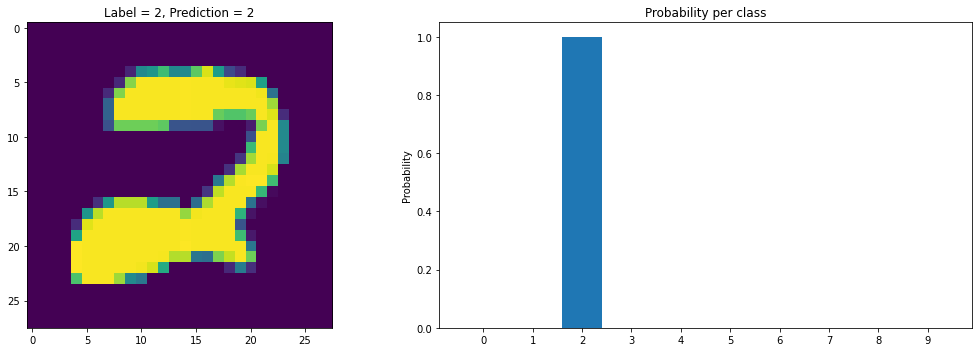

In [24]:
# Correct predictions
true_preds = output.argmax(-1) == y_true

# Predict class probs (higher softmax)
probs_preds = output.gather(-1, preds.view(-1,1)).ravel()

# mask wrong predictions with -inf
mask_wrong = probs_preds.masked_fill(~true_preds, float('-inf'))


print('\n Max Tensor value and index:')
result = torch.max(mask_wrong, -1)
print(result, '\n')
plot_img_and_probs(dataset_train[result.indices], output[result.indices])



## Qual é a amostra classificada erradamente, com maior probabilidade?



 Max Tensor value and index:
torch.return_types.max(
values=tensor(0.9588),
indices=tensor(220)) 

Class Probabilities


,0,1,2,3,4,5,6,7,8,9
probs,5.577385e-10,0.958806,0.001288,0.000004,0.000999,0.000073,0.000031,0.000002,0.03839,0.000408


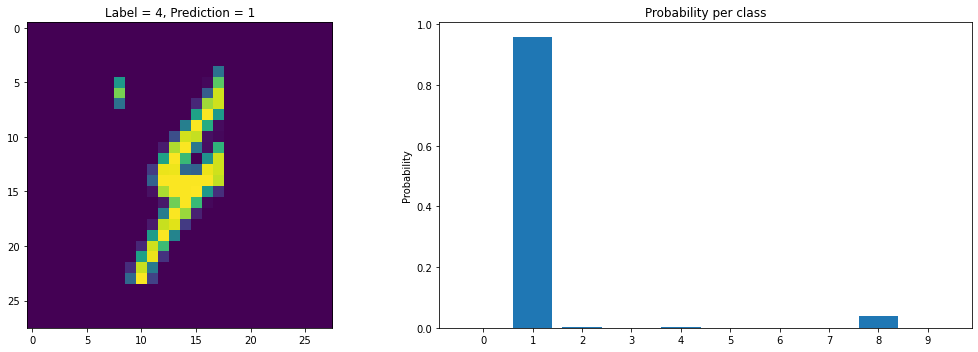

In [25]:
# mask wrong predictions with -inf
mask_wrong = probs_preds.masked_fill(true_preds, float('-inf'))


print('\n Max Tensor value and index:')
result = torch.max(mask_wrong, -1)
print(result, '\n')
plot_img_and_probs(dataset_train[result.indices], output[result.indices])

## Qual é a amostra classificada corretamente, com menor probabilidade?


 Min Tensor value and index:
torch.return_types.min(
values=tensor(0.2942),
indices=tensor(873)) 

Class Probabilities


,0,1,2,3,4,5,6,7,8,9
probs,0.200353,2.603840e-09,0.282256,0.010274,0.023537,0.117711,0.29424,0.000074,0.071473,0.000081


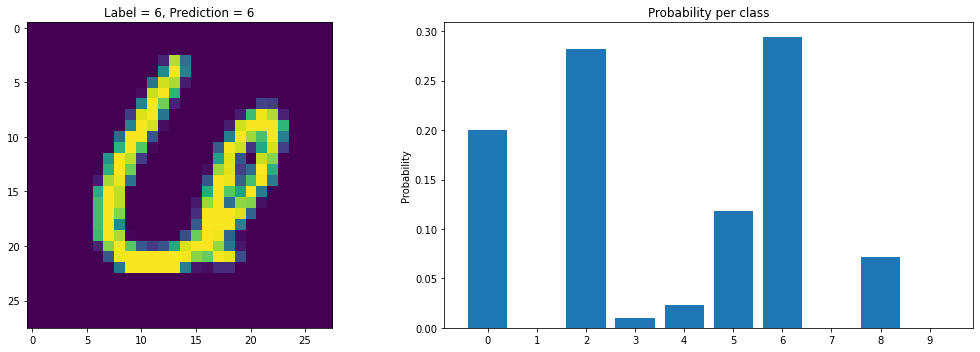

In [26]:
# mask wrong predictions with inf
mask_wrong = probs_preds.masked_fill(~true_preds, float('inf'))


print('\n Min Tensor value and index:')
result = torch.min(mask_wrong, -1)
print(result, '\n')
plot_img_and_probs(dataset_train[result.indices], output[result.indices])

## Qual é a amostra classificada erradamente, com menor probabilidade?





 Min Tensor value and index:
torch.return_types.min(
values=tensor(0.3811),
indices=tensor(556)) 

Class Probabilities


,0,1,2,3,4,5,6,7,8,9
probs,0.195921,0.001223,0.173612,0.005573,1.278676e-13,0.381141,0.001493,2.130060e-08,0.241036,5.355601e-09


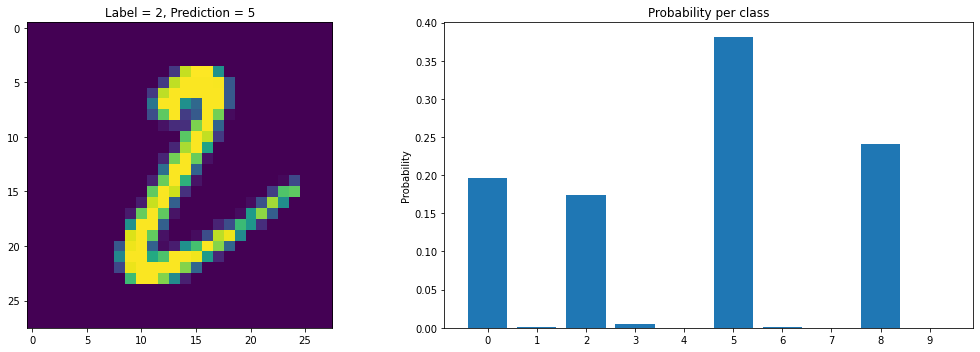

In [27]:
# mask wrong predictions with inf
mask_wrong = probs_preds.masked_fill(true_preds, float('inf'))


print('\n Min Tensor value and index:')
result = torch.min(mask_wrong, -1)
print(result, '\n')
plot_img_and_probs(dataset_train[result.indices], output[result.indices])

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.


In [45]:
class Ex4_DistributedDataloader():
    def __init__(self, dataset, batch_size, class_weights, replacement=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.replacement = replacement

        # Precisa dar uma passada pra pegar o peso de cada amostra de acordo
        # com a classe
        labels = torch.cat(([torch.tensor([self.dataset[idx][1]], dtype=torch.int64) for idx in range(len(dataset))]), 0)

        self.sample_weights = torch.cat([
            self.class_weights[
                  labels[i:i+self.batch_size].ravel()
                  ]
            for i in range(0, len(self.dataset), self.batch_size)
        ])
    
    def reset_generator(self):
        # Returns a tensor where each row contains num_samples indices sampled 
        # from the multinomial probability distribution located in the corresponding 
        # row of tensor input. https://pytorch.org/docs/stable/generated/torch.multinomial.html
        indices = torch.multinomial(self.sample_weights, len(self.dataset),
                                    replacement=self.replacement)
        self.indices_generator = iter(torch.split(indices, self.batch_size))

    def __len__(self):
        return math.floor(len(self.dataset) / self.batch_size)

    def __iter__(self):
        self.reset_generator()
        return self
    
    def __next__(self):
        #try:
            #print("try")
            indices = next(self.indices_generator)
            #print("ret")
            idxs = [torch.tensor(idx, dtype=torch.int64) for idx in indices]
            inputs = [torch.unsqueeze(self.dataset[idx][0], 0) for idx in idxs]
            labels = [torch.tensor([self.dataset[idx][1]], dtype=torch.int64) for idx in idxs]
            #inputs, labels = self.dataset[idxs]
            return torch.cat((inputs), 0), torch.cat((labels), 0)
            #return [self.dataset[idx] for idx in idxs]
        #except:
        #    print("stop")
        #    raise StopIteration
            

In [46]:
distributed_dataloader = Ex4_DistributedDataloader(
    dataset = dataset_train,
    batch_size = 100,
    class_weights = torch.tensor([0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))


In [47]:
import seaborn as sns
sns.set_style('darkgrid')

def dist_per_epochs(dataloader, n_epochs, n_classes=10):
    epochs = []
    for epoch in tqdm(range(n_epochs)):
        epoch_count = torch.zeros(n_classes)
        for batch in dataloader:
            _, y = batch
            epoch_count += y.ravel().bincount(minlength=n_classes)
        epochs.append(epoch_count)
    print(f"n epochs: {len(range(n_epochs))}, len(epochs): {len(epochs)}")     
    epochs = torch.stack(epochs)
    dist = epochs / epochs.sum(1, keepdim=True)

    plt.figure(figsize=(10,5))
    sns.boxplot(data=dist, showmeans=True, showfliers=False)
    plt.title('Boxplot distribution of classes per epochs')
    plt.xlabel('Classes')
    plt.ylabel('(%))')
    plt.show()

def dist_per_batches(dataloader, n_epochs, n_classes=10):
    epochs = []
    for epoch in tqdm(range(n_epochs)):
        for batch in dataloader:
            _, y = batch
            epochs.append(y.ravel().bincount(minlength=n_classes))
    print(f"n epochs: {len(range(n_epochs))}, len(epochs): {len(epochs)}")        
    epochs = torch.stack(epochs)
    dist = epochs / epochs.sum(1, keepdim=True)

    plt.figure(figsize=(10,5))
    sns.boxplot(data=dist, showmeans=True, showfliers=False)
    plt.title('Boxplot distribution of classes per batches')
    plt.xlabel('Classes')
    plt.ylabel('(%))')
    plt.show()



 With replacement


100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


n epochs: 1000, len(epochs): 1000


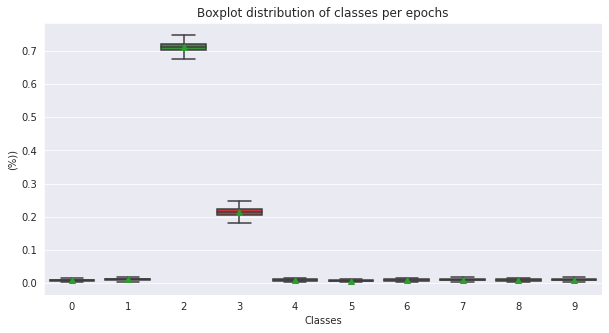

100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]


n epochs: 1000, len(epochs): 10000


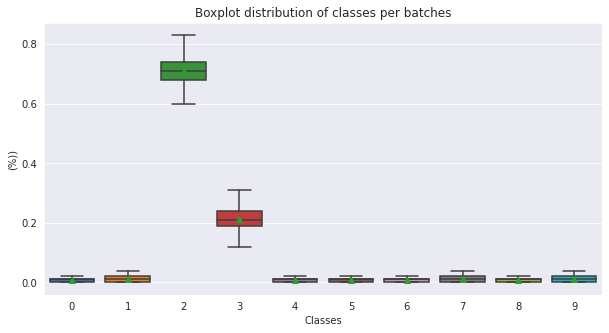


 Without replacement


100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


n epochs: 1000, len(epochs): 1000


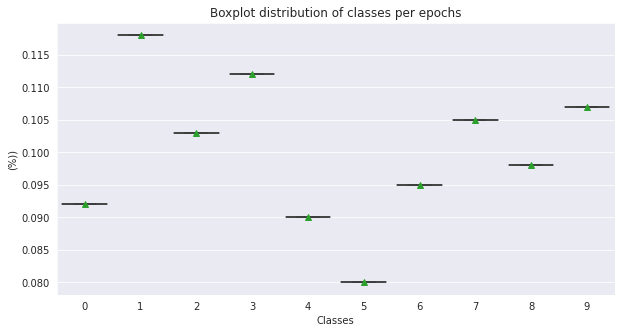

100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]


n epochs: 1000, len(epochs): 10000


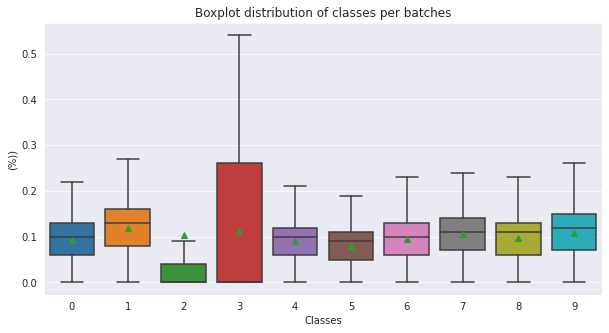

In [48]:

print('\n With replacement')
dist_per_epochs(distributed_dataloader, 1000, 10)
dist_per_batches(distributed_dataloader, 1000, 10)

print('\n Without replacement')
distributed_dataloader.replacement = False
dist_per_epochs(distributed_dataloader, 1000, 10)
dist_per_batches(distributed_dataloader, 1000, 10)

In [50]:
loader_train = Ex4Dataloader(dataset_train, 100, False)

100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s]


n epochs: 1000, len(epochs): 1000


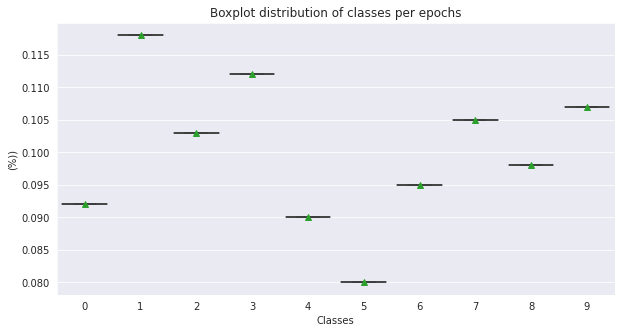

100%|██████████| 1000/1000 [03:05<00:00,  5.40it/s]


n epochs: 1000, len(epochs): 10000


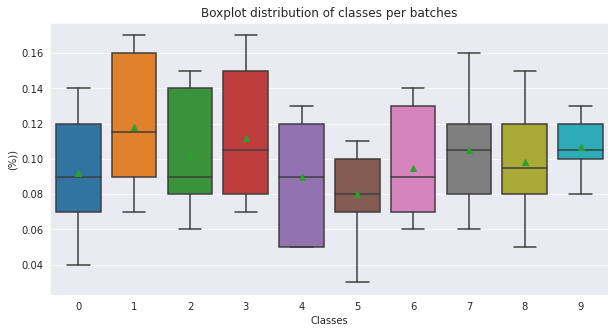

In [51]:
dist_per_epochs(loader_train, 1000, 10)
dist_per_batches(loader_train, 1000, 10)